# Tweet Classification

In [ ]:
! pip install -U kaggle transformers pandas tqdm scikit-learn numpy --quiet

In [ ]:
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm_notebook
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import RocCurveDisplay, roc_curve, accuracy_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline as MLPipeline
from sklearn.model_selection import train_test_split
from fastai.imports import *
import kaggle
np.set_printoptions(linewidth=130)

tqdm.pandas()

In [ ]:
path = Path("/tmp/")
kaggle.api.dataset_download_cli("ashwiniyer176/toxic-tweets-dataset", force=True, path=path)
! unzip {path / "toxic-tweets-dataset.zip"}

Dataset URL: https://www.kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset
License(s): unknown


100%|██████████| 2.21M/2.21M [00:00<00:00, 13.6MB/s]

Archive:  /tmp/toxic-tweets-dataset.zip
  inflating: FinalBalancedDataset.csv  


In [ ]:
df = pd.read_csv(Path(".") / "FinalBalancedDataset.csv")
! rm {Path(".") / "FinalBalancedDataset.csv"}
df = df.drop("Unnamed: 0", axis=1)
df.head(2)

,Toxicity,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked


In [ ]:
df.Toxicity.value_counts()

Toxicity
0    32592
1    24153
Name: count, dtype: int64

In [ ]:
df.loc[df.Toxicity==1, :].head(2)

,Toxicity,tweet
13,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
def tokenizefn(s): return tokenizer.tokenize(s)

In [ ]:
X, y = list(df.tweet.values.tolist()), df.Toxicity.values.tolist()

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
len(x_train), len(x_valid), len(y_train), len(y_valid)

(45396, 11349, 45396, 11349)

In [ ]:
tfidf = TfidfVectorizer(tokenizer=tokenizefn, vocabulary=tokenizer.vocab, lowercase=False)
# pca = PCA(n_components=512)
svd = TruncatedSVD(n_components=512)
rf = RandomForestClassifier()
model = MLPipeline(
    [('tfidf', tfidf), 
     # ('pca', pca), 
     ('svd',svd),
     ('rf', rf)])

In [ ]:
model.fit(x_train, y_train)

/Users/akhilvempali/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
y_preds = model.predict_proba(x_valid)

In [ ]:
y_preds = y_preds[:, 1]

In [ ]:
fpr, tpr, _ = roc_curve(y_valid, y_preds, pos_label=model.classes_[1])

/Users/akhilvempali/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


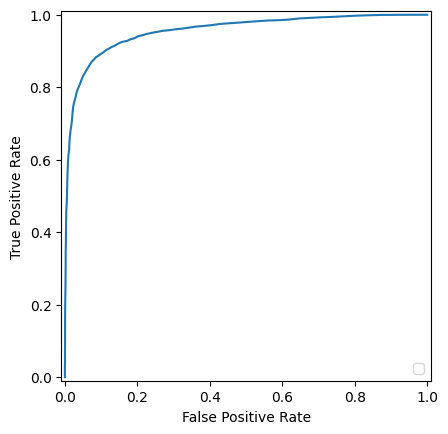

In [ ]:
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
thresh = 0.5
labels = [1 if x>thresh else 0 for x in y_preds]
accuracy = accuracy_score(y_valid, labels)
f1 = f1_score(y_valid, labels)
print(f"{accuracy=}, {f1=}")

accuracy=0.9026345933562429, f1=0.8806824317028399


In [ ]:
confusion_matrix(y_valid, labels)

array([[6166,  460],
       [ 645, 4078]])